[Github](https://github.com/trtd56/RFCX)

In [1]:
import pickle
import numpy as np
import pandas as pd

In [2]:
tp = pd.read_csv('/content/drive/MyDrive/Rainforest/input/train_tp.csv')
fp = pd.read_csv('/content/drive/MyDrive/Rainforest/input/train_fp.csv')

# Что такое псевдо-маркировка? [kaggle](https://www.kaggle.com/cdeotte/pseudo-labeling-qda-0-969)

Псевдо-маркировка - это процесс добавления достоверно предсказанных тестовых данных к вашим обучающим данным. Псевдо-маркировка - это 5-шаговый процесс.
- (1) Постройте модель, используя данные обучения.
- (2) Предсказать метки для невидимого тестового набора данных.
- (3) Добавьте достоверные предсказанные тестовые наблюдения к нашим обучающим данным.
- (4) Создайте новую модель, используя комбинированные данные.
- (5) используйте вашу новую модель, чтобы спрогнозировать тестовые данные 

In [3]:
with open('/content/drive/MyDrive/Rainforest/trtd56/exp0153_resnet18_focal_mixup_pseudo0.5_thr0.5.pkl', 'rb') as f:
    psedo_l = pickle.load(f)

pl = psedo_l['0099c367b_posi']
pl

array([[ 0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,  0,  1,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  1,  0,  0,  0,  0,  0,  0]])

In [ ]:
tp[tp.recording_id == '0099c367b']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
3,0099c367b,17,4,51.4206,1464.26,55.1996,4565.04


In [ ]:
fp[fp.recording_id == '0099c367b']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max



Обратите внимание, что _posi и _nega в конце не имеют ничего общего с фактическими положительными и отрицательными числами.
Как определить, откуда метка: tp_train или fp_train
Так что будьте осторожны, так как некоторые из них носятся (хорошо интегрируются при использовании)

Размер изображения 3751x128 пикселей, но он разделен на 512 окон.

Другими словами, каждый кадр соответствует фактическому размеру следующим образом.

Время пикселя кадра

    0 от 0 до 512 от 0 до 8
    1 463 ~ 975 7 ~ 15
    2 926 ~ 1438 14 ~ 23
    3 1389-1901 22-30
    4 1852 ~ 2364 29 ~ 37
    5 2315 ~ 2827 37 ~ 45
    6 2778-3290 44-52
    7 3241 ~ 3753 51 ~ 60


Положительная метка 1, когда  модель 3-5 fold будут иметь 0,5 или более.

Отрицательная метка -1, когда значение 0,01 или меньше.

Голоса с идентификатором разновидностей 17 появляются в интервале от 0 до 8 секунд и от 22 до 60 секунд.

In [ ]:
pl[:, 17]

array([1, 0, 0, 1, 1, 1, 1, 1])

В интервале от 22 до 30 секунд нет голосов с идентификатором вида 13 в интервале от 22 до 30 секунд.

In [ ]:
pl[:, 13]

array([ 0,  0,  0, -1,  0,  0,  0,  0])

## Pseudo

In [ ]:
EXP = "exp0127_resnet18_second_st_only_label_loss"
PSEUDO_THR = 0.9

all_fnames = tp_fnames+fp_fnames
train_datasets = SpectrogramFromNpz(all_fnames, "valid")

pseudo_label_dict_lst = []
for fold in range(5):
    print(f"### {fold} ###")
    model.load_state_dict(torch.load(f"{BEST_MODEL}/rfcxnet_f{fold}_best_score_model.bin"))

    pseudo_label_dict = {}
    for fname, (X, y, m) in tqdm.tqdm_notebook(zip(all_fnames, train_datasets), total=len(train_datasets)):
        labels = []
        for h, t in slide_img_pos:
            with torch.no_grad():
                outputs = model(X[:,:,h:t].unsqueeze(0).to(device))
            pred = outputs["clipwise_preds_att_ti"].sigmoid().cpu().numpy()[0]
            if sum(pred > PSEUDO_THR) > 0:
                idx = np.where(pred > PSEUDO_THR)
                _lab = np.eye(24)[idx[0]]
                _lab = (_lab.sum(0) > 0).astype(int)
            else:
                _lab = np.zeros(24)
            labels.append(_lab)
        labels = np.stack(labels).astype(int)
        if labels.sum() == 0:
            continue
        pseudo_label_dict[fname] = labels
    pseudo_label_dict_lst.append(pseudo_label_dict)

In [ ]:
pseudo_label_dict_5fold = {}
for fname in all_fnames:
    labels = []
    for pseudo_label_dict in pseudo_label_dict_lst:
        try:
            label = pseudo_label_dict[fname]
        except KeyError:
            label = np.zeros((8, 24))
        labels.append(label)
    new_label = (np.stack(labels).sum(0) > 2).astype(int)
    if new_label.sum() == 0:
        continue
    pseudo_label_dict_5fold[fname] = new_label

# SED

Модель для задачи SED

Как мы можем обеспечить прогноз с информацией о времени начала и смещения? Для этого модели для задачи SED выводят посегментное прогнозирование вместо вывода агрегированного прогноза для клипа, который обычно используется для модели Audio Tagging.

Как мы можем выводить сегментный прогноз? Идея проста. 

Предположим, мы используем модель на основе 2D CNN, которая принимает журнал-мелспектрограмму в качестве входных данных и извлекает признаки с помощью экстрактора признаков CNN, а также выполняет классификацию с помощью карты признаков, которая является выводом CNN.

Вывод средства извлечения функций CNN по-прежнему содержит информацию о частоте и времени (он должен быть четырехмерным: 
    
    - размер пакета,
    - каналы,
    - частота,
    - время

поэтому, если мы агрегируем его только по оси частот, мы можем сохранить информацию о времени для этой функции. 

Эта карта функций содержит информацию о том, в каком временном отрезке какое звуковое событие произошло.

In [ ]:
tp_dict = {}
for recording_id, df in tp.groupby("recording_id"):
    tp_dict[recording_id] = df.values[:, [1,3,4,5,6]]

fp_dict = {}
for recording_id, df in fp.groupby("recording_id"):
    fp_dict[recording_id] = df.values[:, [1,3,4,5,6]]
    
def extract_seq_label(label, value):
    seq_label = np.zeros((24, 3751))  # label, sequence
    middle = np.ones(24) * -1
    for species_id, t_min, f_min, t_max, f_max in label:
        h, t = int(3751*(t_min/60)), int(3751*(t_max/60))
        m = (t + h)//2
        middle[species_id] = m
        seq_label[species_id, h:t] = value
    return seq_label, middle.astype(int)

In [ ]:
fname = '00204008d'
nega_label, nega_middle = extract_seq_label(fp_dict[fname], -1) 
nega_label, nega_middle

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([  -1,   -1,   -1,   -1,  995,   -1,   -1,   -1, 1660,   -1,   -1,
          -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,  899,
          -1,   -1]))

In [ ]:
fp[fp.recording_id == '00204008d']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,00204008d,21,1,13.8400,3281.25,14.9333,4125.00
1,00204008d,8,1,24.4960,3750.00,28.6187,5531.25
2,00204008d,4,1,15.0027,2343.75,16.8587,4218.75


In [ ]:
fname = "0099c367b"
posi_label, posi_middle = extract_seq_label(tp_dict[fname], 1) 
posi_label, posi_middle

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([  -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
          -1,   -1,   -1,   -1,   -1,   -1, 3332,   -1,   -1,   -1,   -1,
          -1,   -1]))

In [ ]:
tp[tp.recording_id == '0099c367b']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
3,0099c367b,17,4,51.4206,1464.26,55.1996,4565.04


In [ ]:
posi_label.shape

(24, 3751)

In [ ]:
 h, t = int(3751*(t_min/60)), int(3751*(t_max/60))

In [ ]:
t_min, t_max = 51.4206, 55.1996

In [ ]:
3751 * t_min/60

3214.64451

In [ ]:
from tqdm import notebook
train_tp = pd.read_csv('/content/drive/MyDrive/Rainforest/input/train_tp.csv')
train_fp = pd.read_csv('/content/drive/MyDrive/Rainforest/input/train_fp.csv')


tp_dict = {}
for recording_id, df in train_tp.groupby("recording_id"):
    tp_dict[recording_id+"_posi"] = df.values[:, [1,3,4,5,6]]

fp_dict = {}
for recording_id, df in train_fp.groupby("recording_id"):
    fp_dict[recording_id+"_nega"] = df.values[:, [1,3,4,5,6]]

"""просто группируем по ид
        - поскольку у нас есть дубликаты мы их группируем

"""

tp_fnames, tp_labels = [], []
for recording_id, df in train_tp.groupby("recording_id"):
    v = sum([np.eye(24)[i] for i in df["species_id"].tolist()])
    v = (v  == 1).astype(int).tolist()
    tp_fnames.append(recording_id+"_posi")
    tp_labels.append(v)

fp_fnames, fp_labels = [], []
for recording_id, df in train_fp.groupby("recording_id"):
    v = sum([np.eye(24)[i] for i in df["species_id"].tolist()])
    v = (v  == 1).astype(int).tolist()
    fp_fnames.append(recording_id+"_nega")
    fp_labels.append(v)
"""
тут просто делаем метку одну для всех дубликатах
"""

In [ ]:
fp_fnames[:2], fp_labels[:2]

(['00204008d_nega', '003b04435_nega'],
 [[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

In [ ]:
fp[fp.recording_id == '00204008d']

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,00204008d,21,1,13.8400,3281.25,14.9333,4125.00
1,00204008d,8,1,24.4960,3750.00,28.6187,5531.25
2,00204008d,4,1,15.0027,2343.75,16.8587,4218.75


In [ ]:
npy = np.load('/content/drive/MyDrive/Rainforest/trtd56/00204008d.npy')

In [ ]:
npy.shape

(128, 3751)

In [ ]:
import random

def mono_to_color(
    X: np.ndarray, mean=None, std=None,
    norm_max=None, norm_min=None, eps=1e-6
):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def extract_seq_label(label, value):
    seq_label = np.zeros((24, 3751))
    middle = np.ones(24) * -1
    for species_id, t_min, f_min, t_max, f_max in label:
        h, t = int(3751*(t_min/60)), int(3751*(t_max/60))
        m = (t + h)//2
        middle[species_id] = m
        seq_label[species_id, h:t] = value
    return seq_label, middle.astype(int)


class TimeMask:
    def __init__(self, T=40, num_masks=1, replace_with_zero=True):
        self.T = T
        self.num_masks = num_masks
        self.replace_with_zero = replace_with_zero

    def __call__(self, spec):
        cloned = spec.copy()
        print(cloned.shape)
        len_spectro = cloned.shape[2]
    
        for i in range(0, self.num_masks):
            print(self.T)
            t = random.randrange(0, self.T)
            t_zero = random.randrange(0, len_spectro - t)

            # avoids randrange error if values are equal and range is empty
            if (t_zero == t_zero + t): return cloned

            mask_end = random.randrange(t_zero, t_zero + t)
            if (self.replace_with_zero): cloned[:,:,t_zero:mask_end] = 0
            else: cloned[:,:,t_zero:mask_end] = cloned.mean()
        return cloned

class FreqMask:
    def __init__(self, F=30, num_masks=1, replace_with_zero=True):
        self.F = F
        self.num_masks = num_masks
        self.replace_with_zero = replace_with_zero

    def __call__(self, spec):
        cloned = spec.copy()
        num_mel_channels = cloned.shape[1]
    
        for i in range(0, self.num_masks):        
            f = random.randrange(0, self.F)
            f_zero = random.randrange(0, num_mel_channels - f)

            # avoids randrange error if values are equal and range is empty
            if (f_zero == f_zero + f): return cloned

            mask_end = random.randrange(f_zero, f_zero + f) 
            if (self.replace_with_zero): cloned[:, f_zero:mask_end] = 0
            else: cloned[:, f_zero:mask_end] = cloned.mean()
    
        return cloned

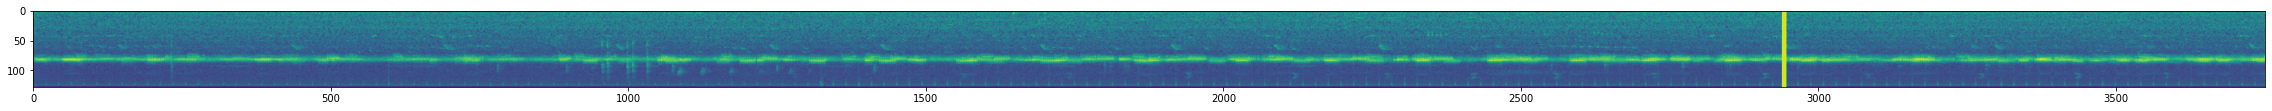

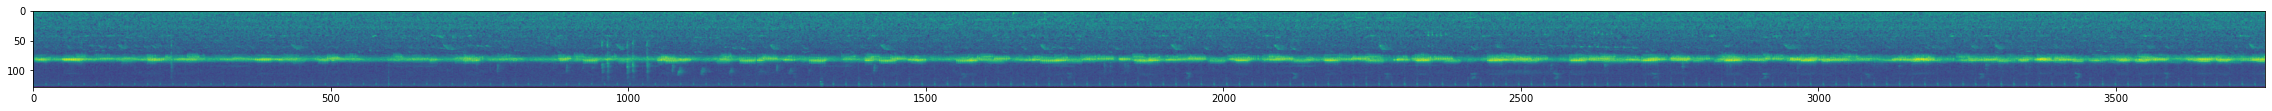

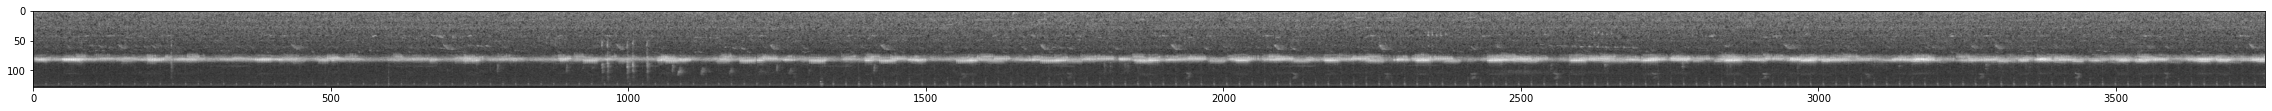

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 400))
plt.imshow(FreqMask()(npy))
plt.savefig('freqmask.jpg')
plt.show()
plt.figure(figsize=(40, 400))
plt.imshow(npy)
plt.savefig('npy.jpg')
plt.figure(figsize=(40, 400))
a = mono_to_color(npy)
aa = TimeMask()(a)
plt.imshow(aa)
plt.savefig('foo.jpg')